In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter('ignore', category=ConvergenceWarning)
import argparse
from torch.distributions import MultivariateNormal
from sklearn.model_selection import train_test_split, GridSearchCV
import os
from pathlib import Path
from scripts.utils import make_dataloader, EarlyStopping, plot_train_history
import json
from scripts.metrics import NegMeanSquaredError
from scripts.train import train_model
from matplotlib.animation import FuncAnimation, FFMpegWriter
from scripts.test import predict
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, make_scorer
from scripts.ntk import get_ntk_feature_matrix

## Data and constants

In [2]:
DEGREE = 6
DATA_SIZE = 10000
NUM_FEATURES = 100
RANGE = 2

In [3]:
cosines_ani_path = f'animations/degree_{DEGREE}_repeat.mp4'

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, width, symmetric_init=True) -> None:
        super().__init__()
        self.width = width
        self.input = nn.Sequential(
            nn.Linear(in_features=NUM_FEATURES, out_features=width),
            nn.ReLU()
        )
        if symmetric_init:
            for param in self.parameters():
                n = len(param)
                first_ws = param[:n//2].detach()
                param.data=torch.cat((first_ws, -first_ws))
        self.output = nn.Sequential(
            nn.Linear(in_features=width, out_features=1)
        )

    def forward(self, x):
        return self.output(self.input(x))
    
    def clone(self):
        new_model = SimpleNN(self.width)
        new_model.load_state_dict(self.state_dict())
        return new_model

    def freeze_first(self) -> None:
        for param in self.input.parameters():
            param.requires_grad = False
        
    def freeze_last(self) -> None:
        for param in self.output.parameters():
            param.requires_grad_(False)
    
    def revive_last(self) -> None:
        for param in self.output.parameters():
            param.requires_grad_(True)
    
    def reinit_last(self) -> None:
        for child in self.output.children():
            if hasattr(child, 'reset_parameters'):
                child.reset_parameters()

In [5]:
distribution = MultivariateNormal(torch.zeros(NUM_FEATURES), torch.eye(NUM_FEATURES))

torch.manual_seed(844) 
X = distribution.sample((DATA_SIZE,))
print(f'X.shape == {X.shape}')

X.shape == torch.Size([10000, 100])


In [6]:
scale_factor = RANGE / X.sum(dim=1).abs().max()
print(f'scale_factor == {scale_factor}')
X *= scale_factor

scale_factor == 0.0473104864358902


In [7]:
roots = torch.linspace(-RANGE, RANGE, DEGREE)
X_sum = X.sum(dim=1)
Y = torch.ones_like(X_sum)
for root in roots:
    Y *= (X_sum - root)
Y.unsqueeze_(1)
print(f'Y.shape == {Y.shape}')

Y.shape == torch.Size([10000, 1])


In [8]:
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.1, random_state=13)
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=1/9, random_state=9173)
print(f'X_train.shape == {X_train.shape}, Y_train.shape == {Y_train.shape}')
print(f'X_val.shape == {X_val.shape}, Y_val.shape == {Y_val.shape}')
print(f'X_test.shape == {X_test.shape}, Y_test.shape == {Y_test.shape}')

X_train.shape == torch.Size([8000, 100]), Y_train.shape == torch.Size([8000, 1])
X_val.shape == torch.Size([1000, 100]), Y_val.shape == torch.Size([1000, 1])
X_test.shape == torch.Size([1000, 100]), Y_test.shape == torch.Size([1000, 1])


In [9]:
Y_LIM = (Y_train.min(), Y_train.max())

In [10]:
train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 32, True), make_dataloader(X_val, Y_val, 32, True)

## NN cross-val and training

In [11]:
device = 'cpu'

In [12]:
def get_cosine_angles(model: SimpleNN, ref_vector: torch.Tensor = torch.ones(NUM_FEATURES)):
    weights = next(model.input.parameters()).detach()
    return torch.tensor([torch.dot(weight, ref_vector) / (torch.linalg.norm(ref_vector) * torch.linalg.norm(weight)) for weight in weights])

In [13]:
config_file = Path(f'configs/nn/hidden-func-poly/degree_{DEGREE}.json')
if config_file.is_file():
    with open(config_file, 'r') as f:
        best_config = json.load(f)
    best_width = best_config['width']
    best_eta = best_config['eta']
    best_weight_decay = best_config['weight_decay']
    best_score = best_config['score']

print(f'Width:{best_width}, lr:{best_eta}, w_d:{best_weight_decay}, score:{best_score}')

Width:512, lr:1.0, w_d:0.0, score:-0.3181394636631012


In [14]:
torch.random.manual_seed(47647)
best_model_nn = SimpleNN(best_width).to(device)
model_0 = best_model_nn.clone()

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adadelta(params=best_model_nn.parameters(), lr=best_eta, weight_decay=best_weight_decay)
metric = NegMeanSquaredError()
early_stop = EarlyStopping(patience=50, min_delta=1e-4)

In [15]:
history = train_model(
    model=best_model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device,
    return_models=True
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.645850, Train score: -0.639215, Val loss: 0.650042, Val score: -0.638395
Epoch: 2 => Train loss: 0.642190, Train score: -0.636446, Val loss: 0.648856, Val score: -0.671007
Epoch: 3 => Train loss: 0.632590, Train score: -0.621022, Val loss: 0.635586, Val score: -0.619529
Epoch: 4 => Train loss: 0.582764, Train score: -0.545971, Val loss: 0.546215, Val score: -0.527385
Epoch: 5 => Train loss: 0.445873, Train score: -0.398666, Val loss: 0.342706, Val score: -0.321196
Epoch: 6 => Train loss: 0.239769, Train score: -0.276945, Val loss: 0.187109, Val score: -0.296789
Epoch: 7 => Train loss: 0.178788, Train score: -0.314208, Val loss: 0.177147, Val score: -0.342112
Epoch: 8 => Train loss: 0.168072, Train score: -0.330092, Val loss: 0.172740, Val score: -0.348126
Epoch: 9 => Train loss: 0.165084, Train score: -0.329505, Val loss: 0.159121, Val score: -0.332517
Epoch: 10 => Train loss: 0.165342, Train score: -0.333

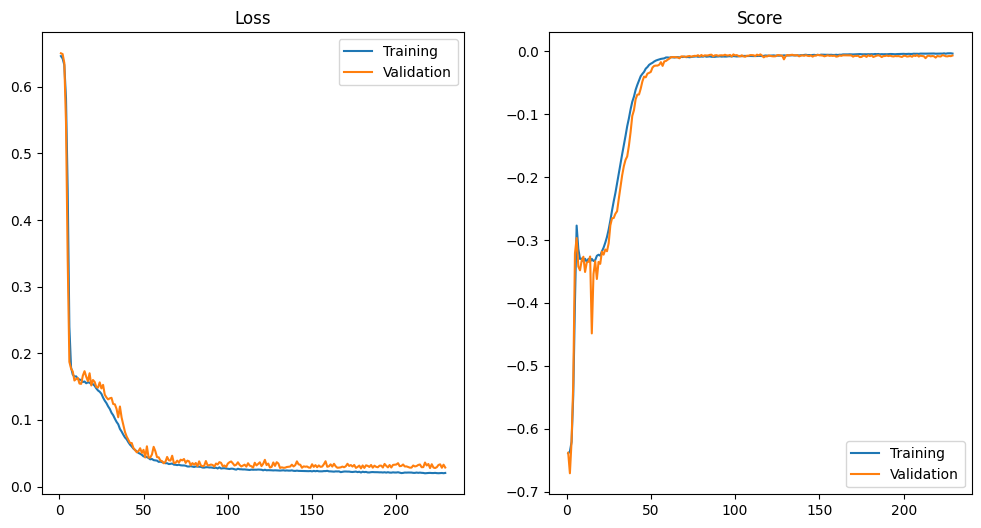

In [16]:
plot_train_history(history)

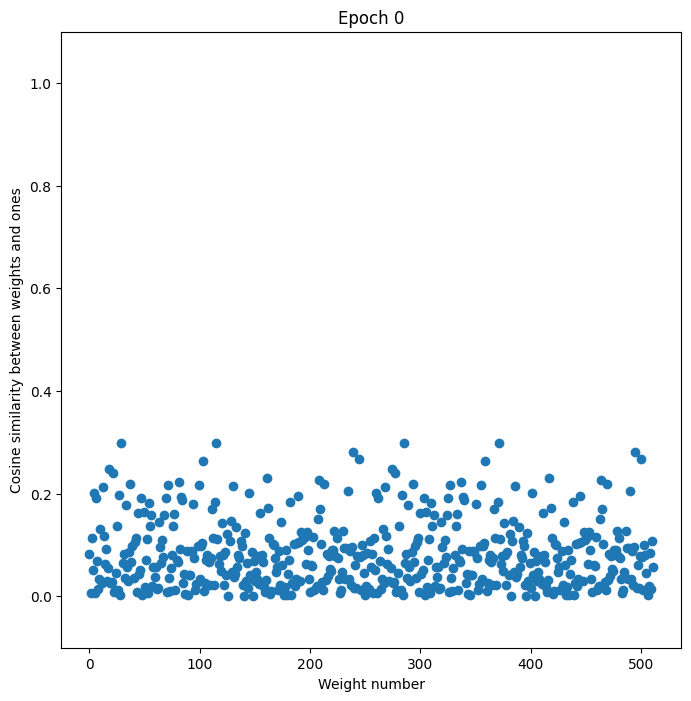

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
FPS = 1.25
models = [model_0] + history['models']

def plot_cosines(i):
    cosines = get_cosine_angles(models[i])
    ax.clear()

    ax.scatter(range(len(cosines)), cosines.abs())
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel('Cosine similarity between weights and ones')
    ax.set_xlabel('Weight number')
    ax.set_title(f'Epoch {i}')

ani = FuncAnimation(fig, plot_cosines, frames=len(models), interval=1000/FPS, repeat=True)
writer = FFMpegWriter(fps=FPS, bitrate=1800, metadata=dict(arist='Me'))

ani.save(cosines_ani_path, writer=writer)

In [18]:
preds_train_nn, preds_val_nn, preds_test_nn = predict(best_model_nn, X_train, device), predict(best_model_nn, X_val, device), predict(best_model_nn, X_test, device)
print(f'preds_train_nn.shape == {preds_train_nn.shape}, preds_val_nn.shape == {preds_val_nn.shape}, preds_test_nn.shape == {preds_test_nn.shape}')

preds_train_nn.shape == torch.Size([8000, 1]), preds_val_nn.shape == torch.Size([1000, 1]), preds_test_nn.shape == torch.Size([1000, 1])


In [19]:
score_train, score_val, score_test = metric(preds_train_nn, Y_train), metric(preds_val_nn, Y_val), metric(preds_test_nn, Y_test)
print(f'score_train == {score_train}, score_val == {score_val}, score_test == {score_test}')

score_train == -0.0034221275709569454, score_val == -0.00655277818441391, score_test == -0.017425594851374626


Text(0.5, 0.98, 'NN')

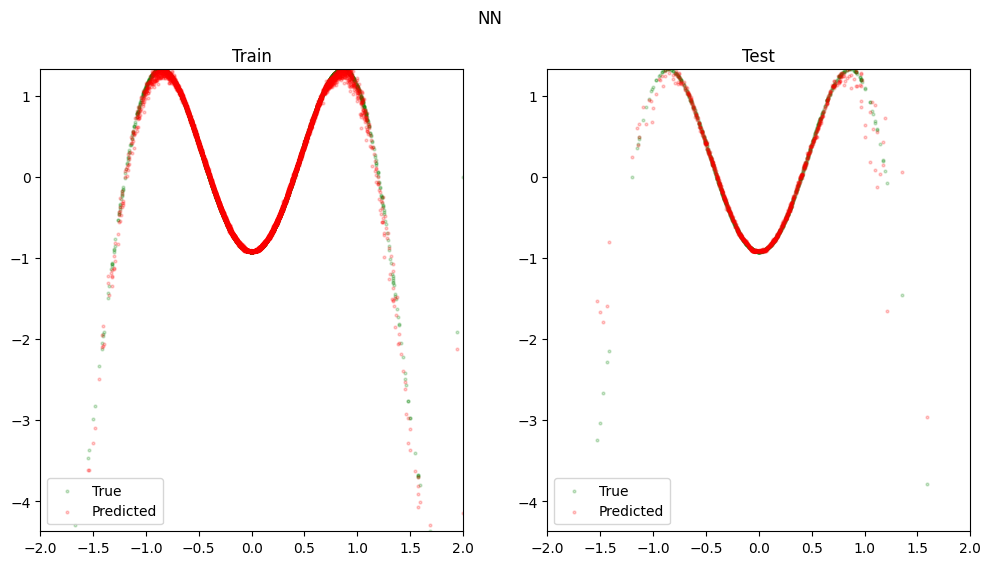

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_train.sum(dim=1), Y_train, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_train.sum(dim=1), preds_train_nn, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Train')
plt.xlim(-RANGE, RANGE)
plt.ylim(Y_LIM)
plt.legend()

plt.subplot(122)
plt.scatter(X_test.sum(dim=1), Y_test, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_test.sum(dim=1), preds_test_nn, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Test')
plt.xlim(-RANGE, RANGE)
plt.ylim(Y_LIM)
plt.legend()

plt.suptitle('NN')

## Alignment verification

In [25]:
KEY_EPOCHS = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 

In [22]:
model_base_ntk = LinearSVR()
params_ntk = {
    'C': np.logspace(-4, 2, 7)
}
scorer = make_scorer(mean_squared_error, greater_is_better=False)
model_cv_ntk = GridSearchCV(
    estimator=model_base_ntk,
    param_grid=params_ntk,
    scoring=scorer,
    n_jobs=1,
    cv=4,
    refit=False
)

In [23]:
if not Path('plots/alignments/').is_dir():
    os.mkdir('plots/alignments')
if not Path('plots/alignments/alignments/').is_dir():
    os.mkdir('plots/alignments/alignments/')
if not Path('plots/alignments/fits/').is_dir():
    os.mkdir('plots/alignments/fits/')

Beginning epoch 7
Best C: 0.01, best score: -0.20957081924280424
Beginning epoch 8
Best C: 0.01, best score: -0.21580476172125918
Beginning epoch 9
Best C: 0.01, best score: -0.2085562074946229
Beginning epoch 10
Best C: 0.01, best score: -0.20923485614263124
Beginning epoch 11
Best C: 0.01, best score: -0.2134941980038632
Beginning epoch 12
Best C: 0.01, best score: -0.2156125860545513
Beginning epoch 13
Best C: 0.01, best score: -0.2088977852437322
Beginning epoch 14
Best C: 0.01, best score: -0.2069234860506758
Beginning epoch 15
Best C: 0.01, best score: -0.21477588423667276
Beginning epoch 16
Best C: 0.01, best score: -0.21906731846282534
Beginning epoch 17
Best C: 0.01, best score: -0.21103737315165036


/tmp/ipykernel_12687/3085228711.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


Beginning epoch 18
Best C: 10.0, best score: -0.1913579652414118
Beginning epoch 19
Best C: 10.0, best score: -0.16540399697028593


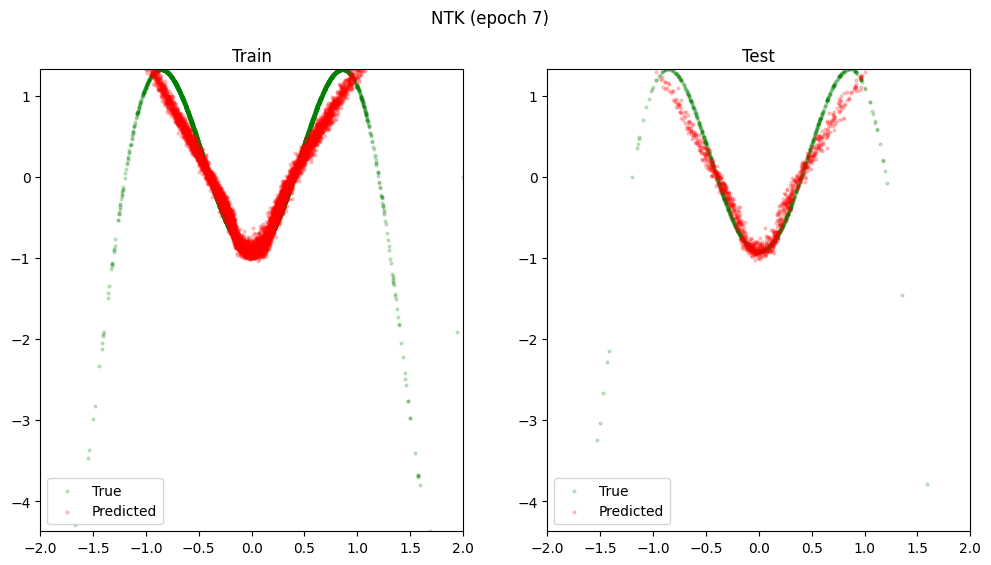

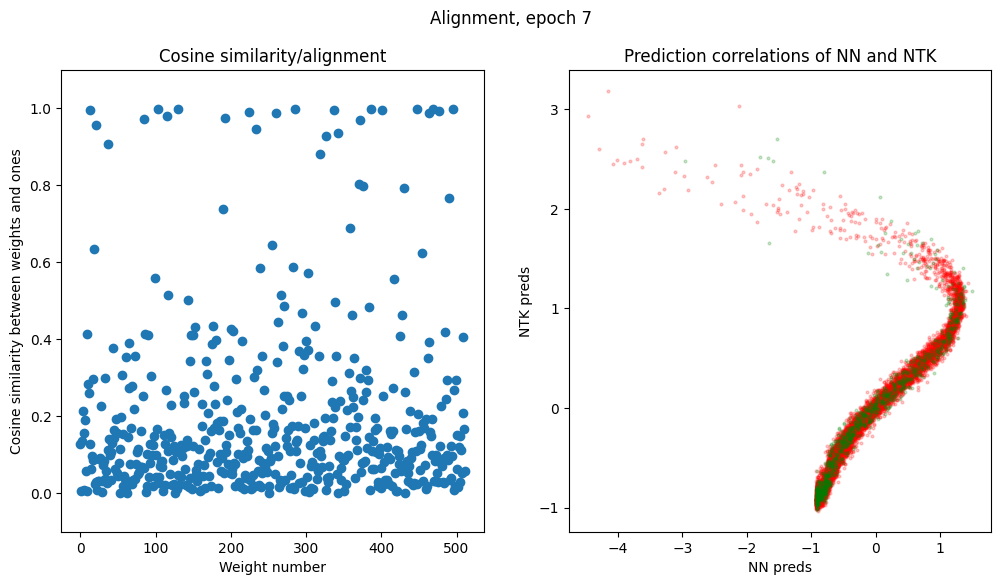

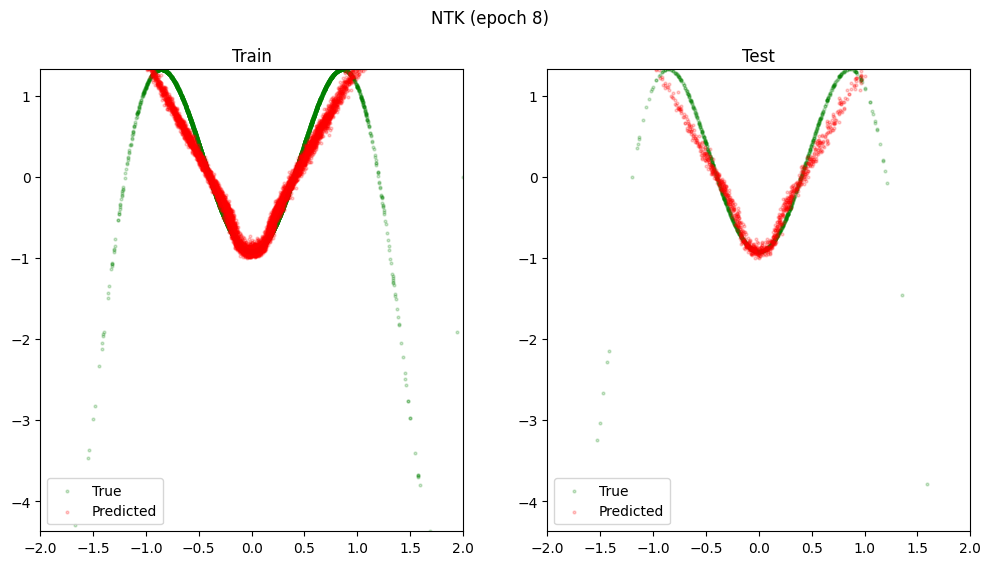

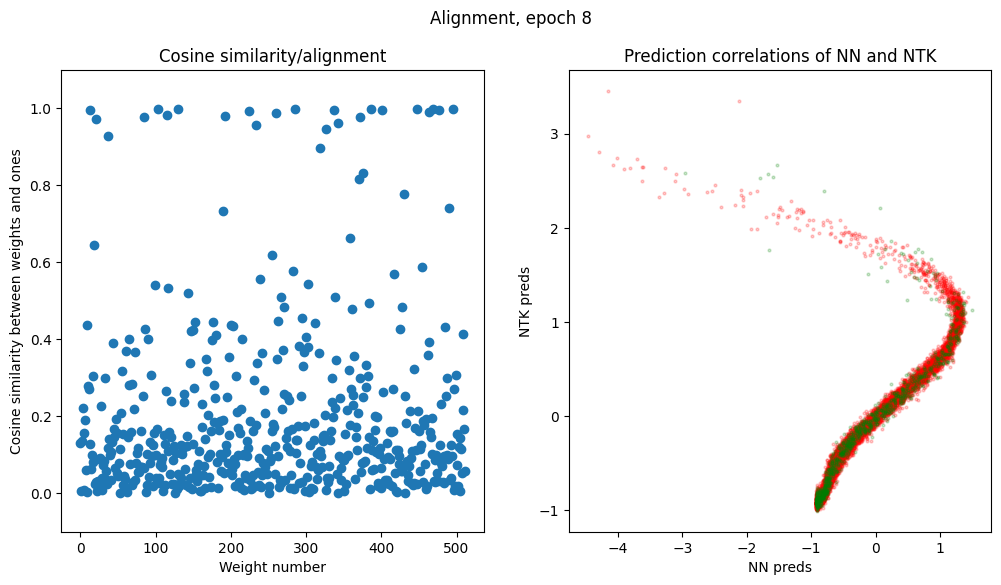

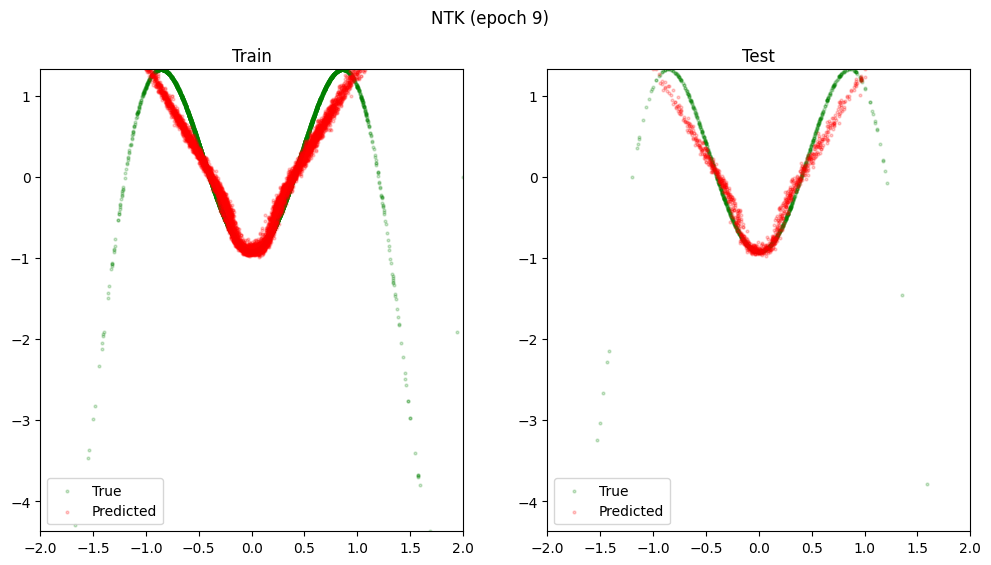

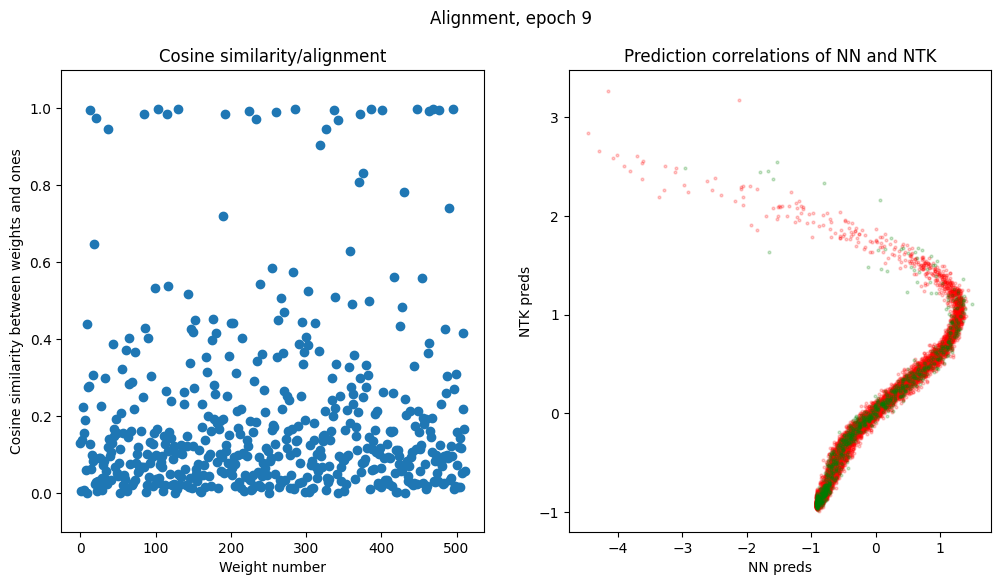

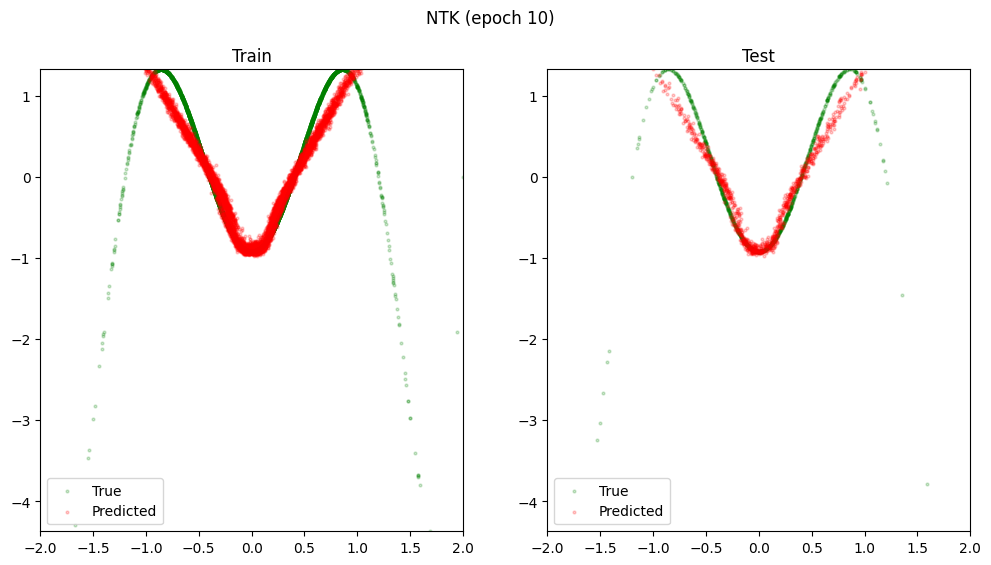

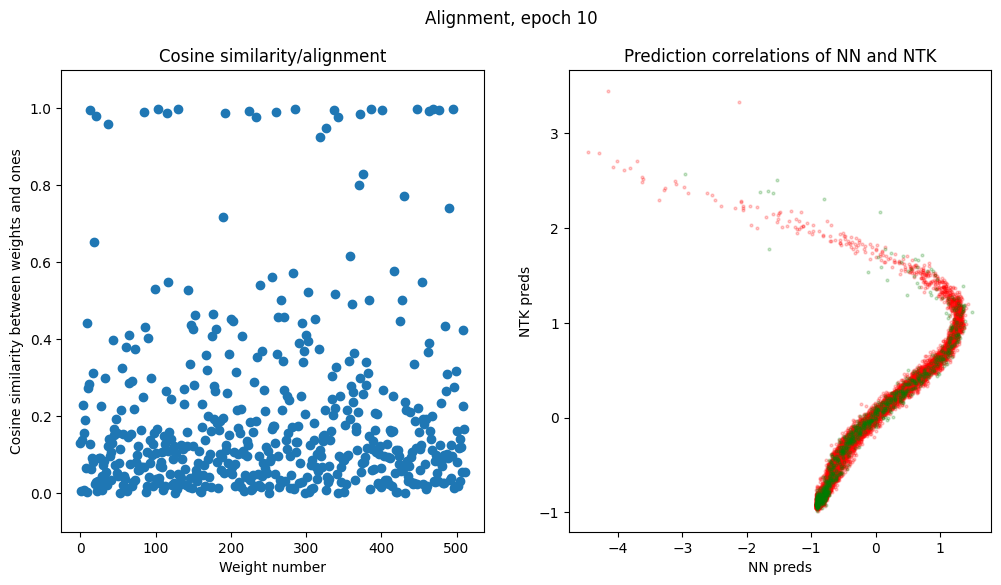

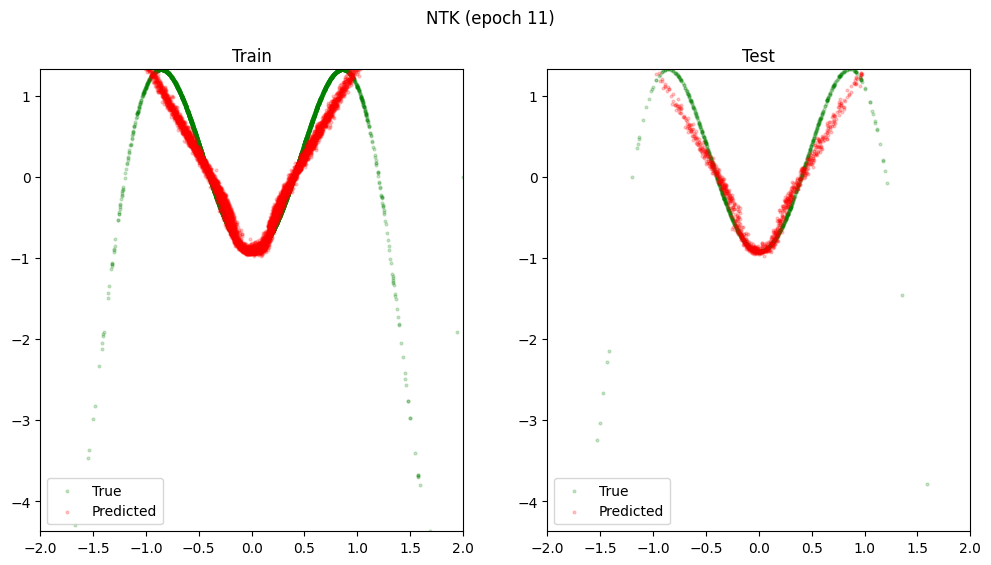

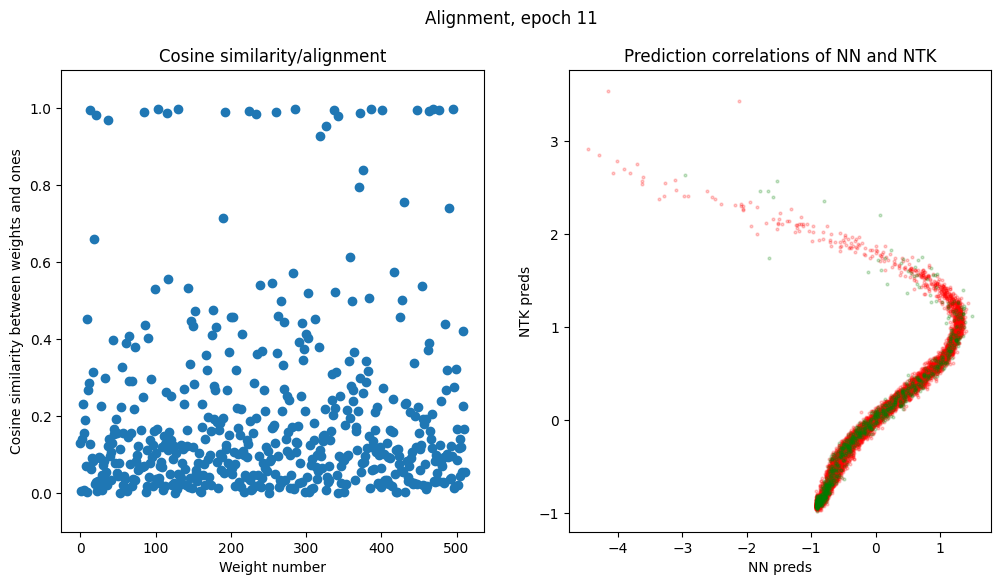

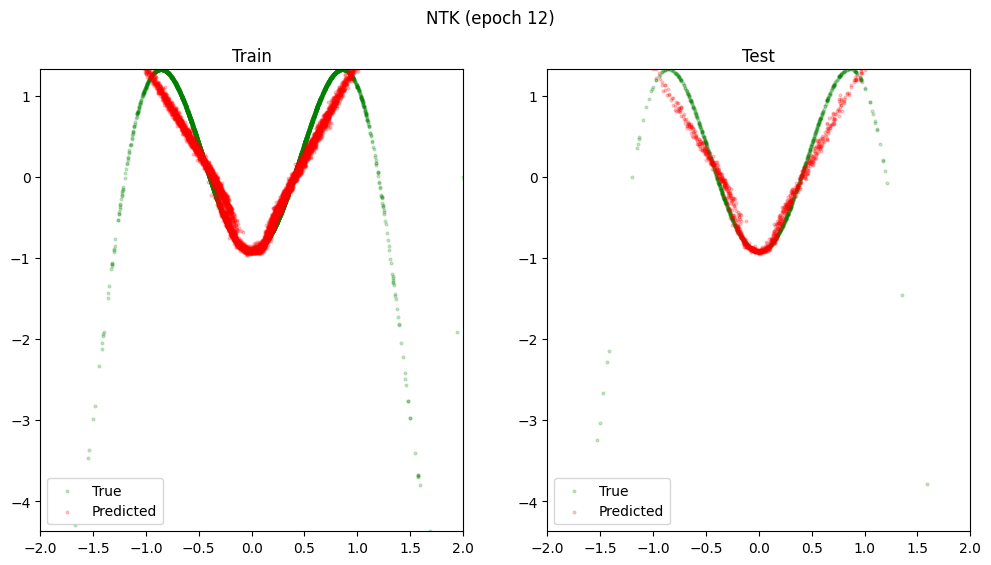

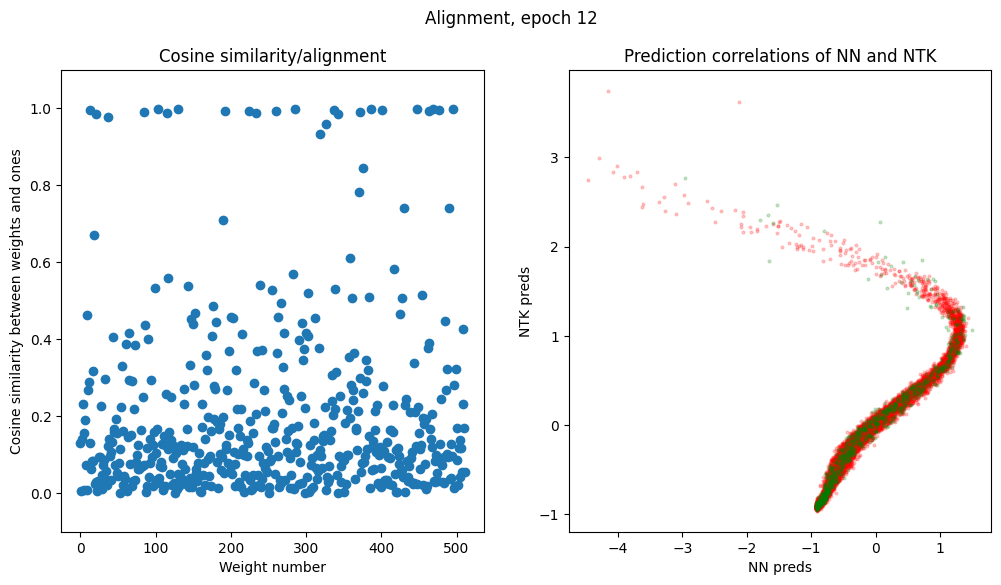

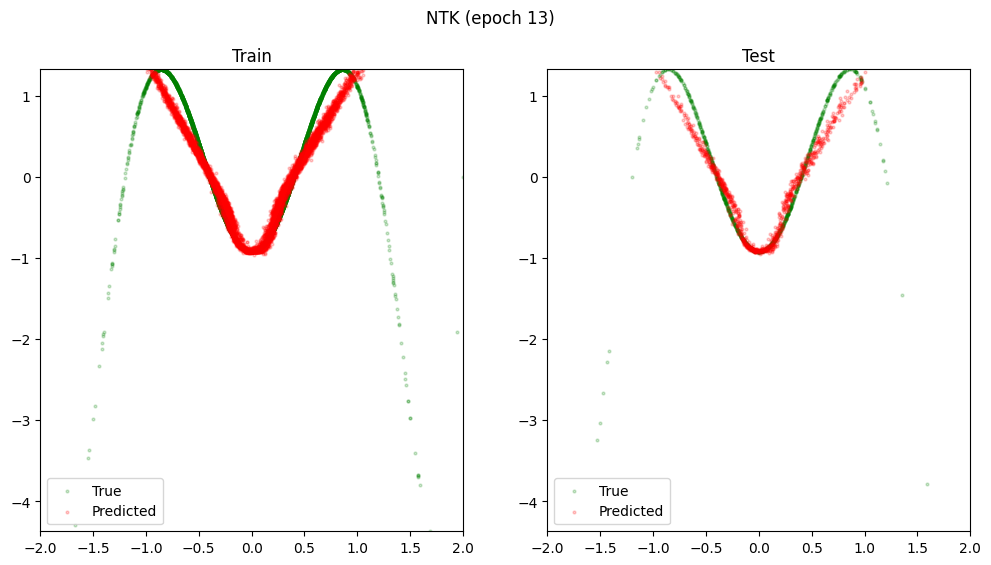

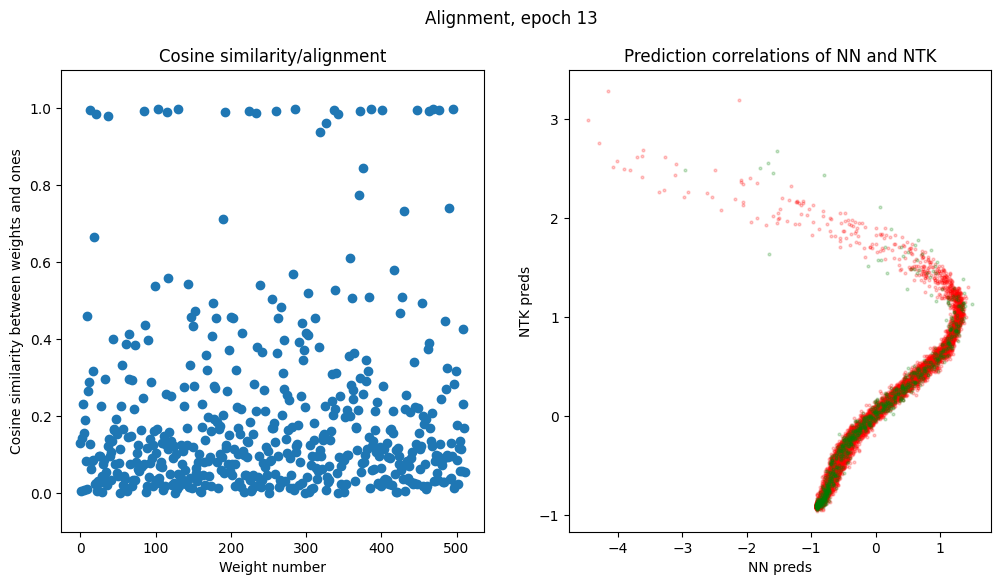

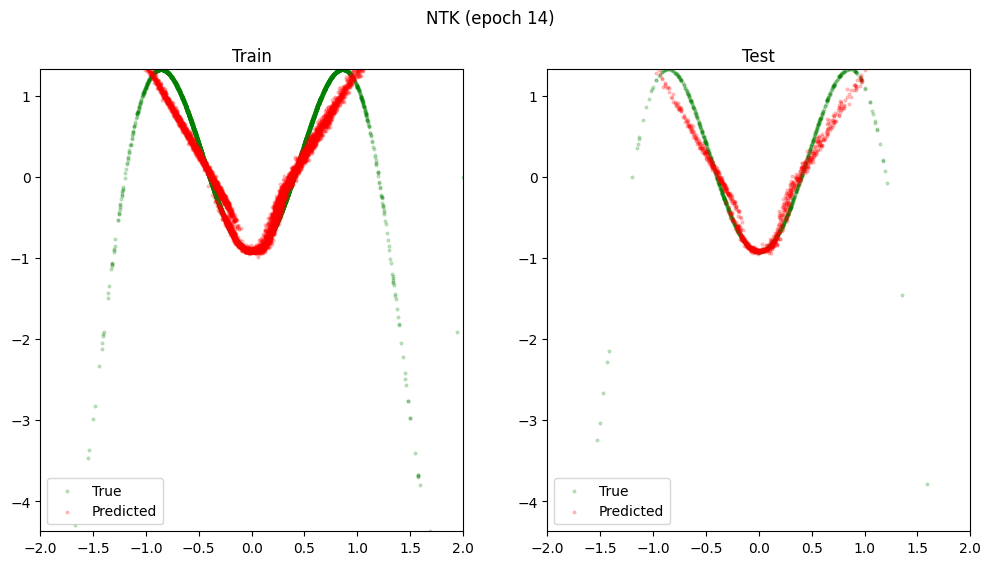

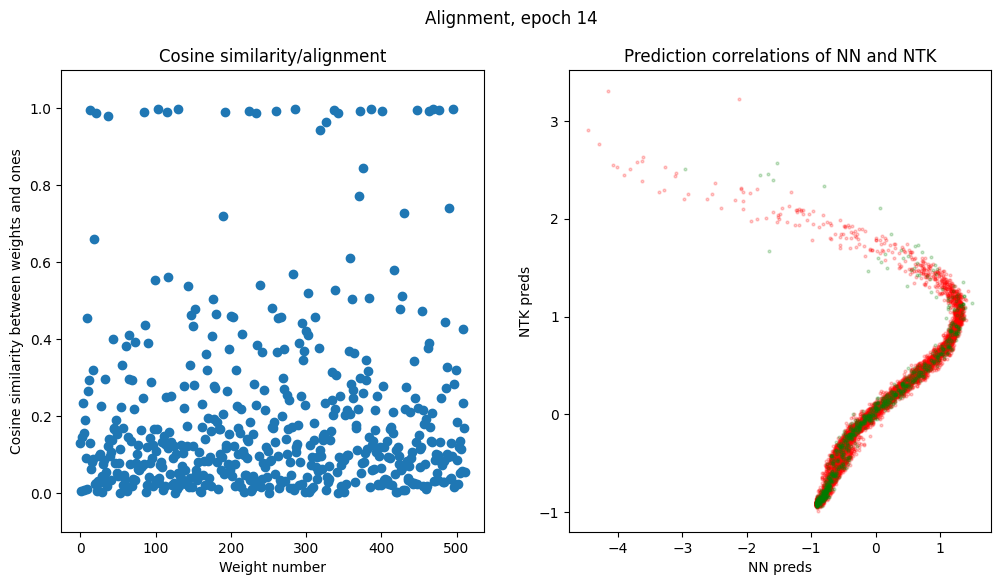

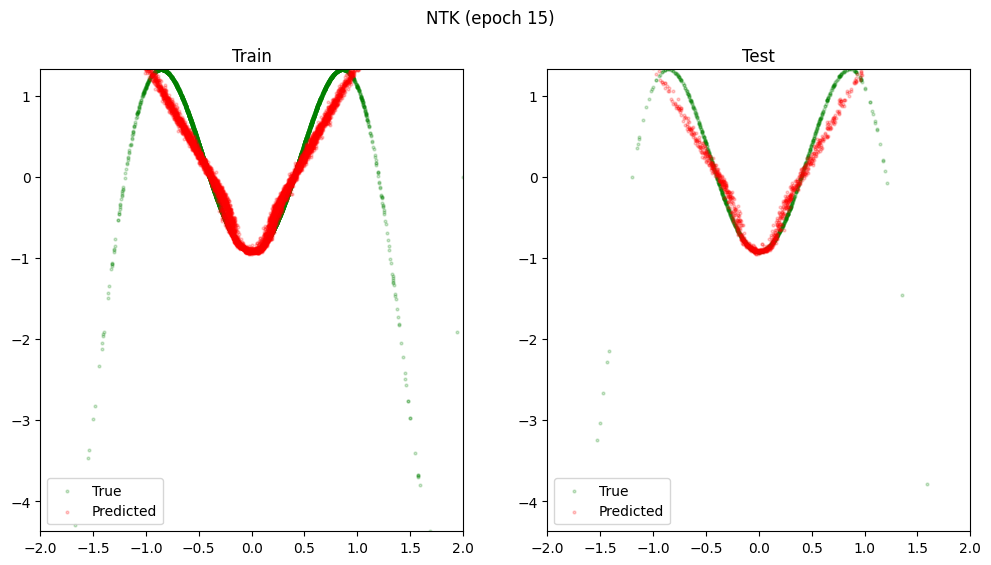

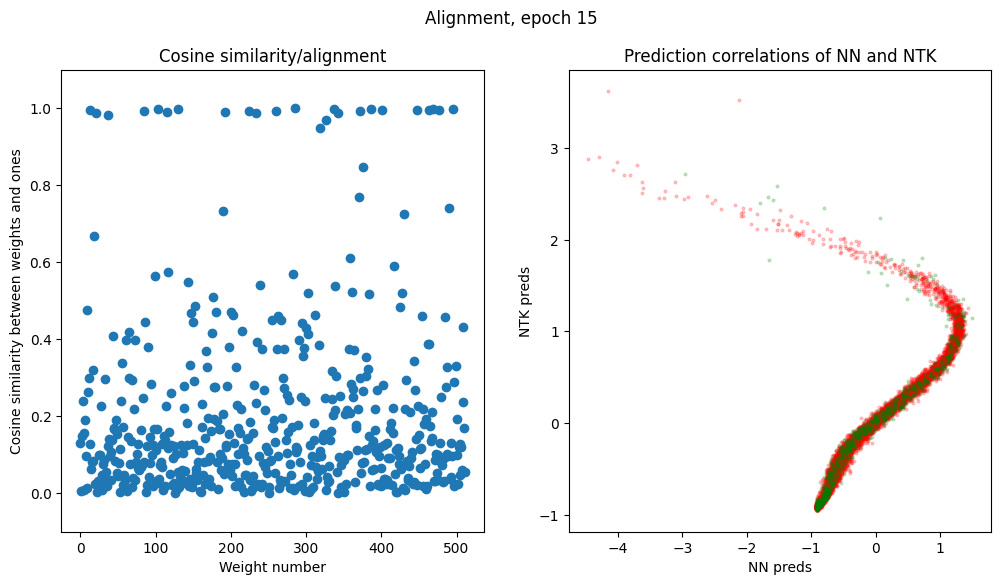

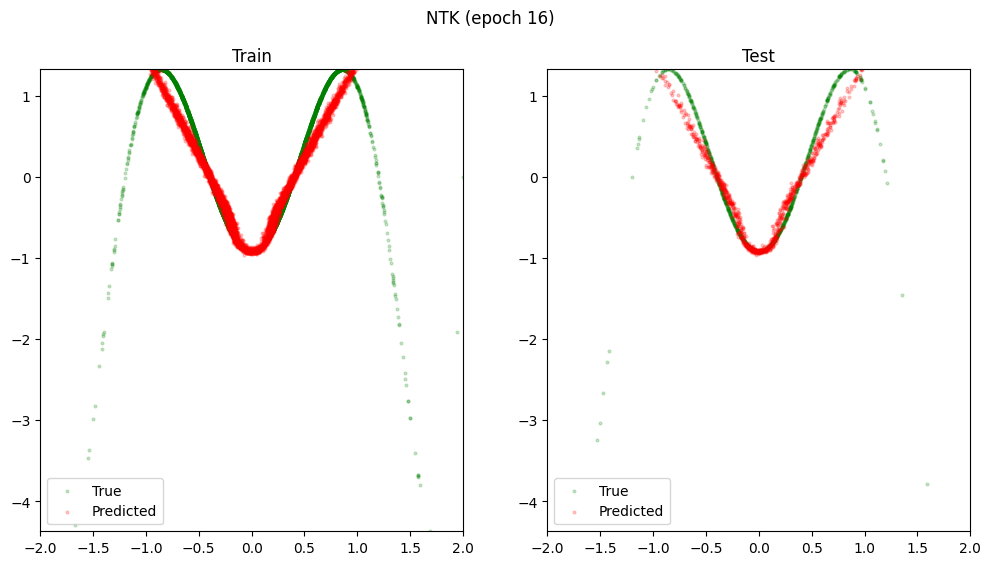

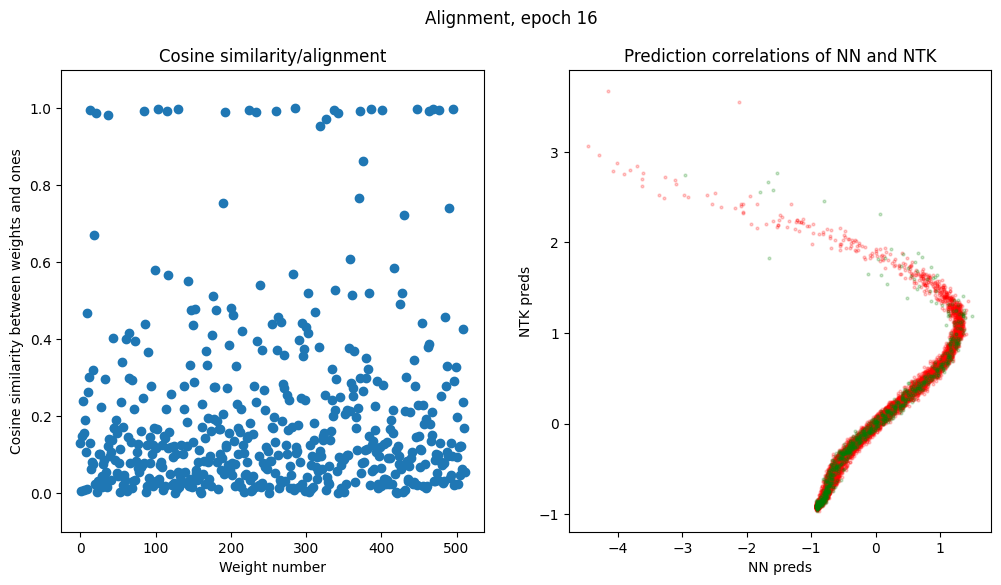

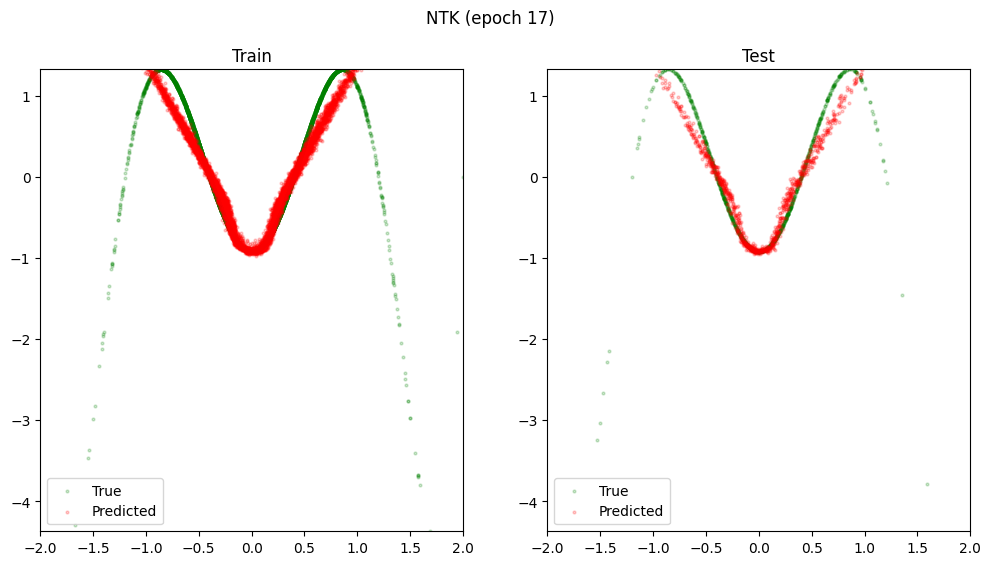

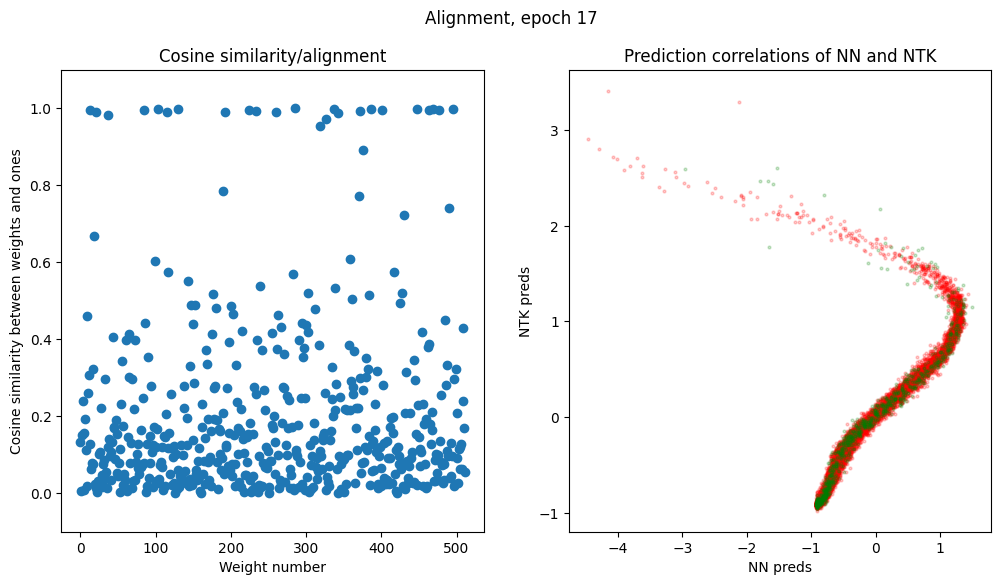

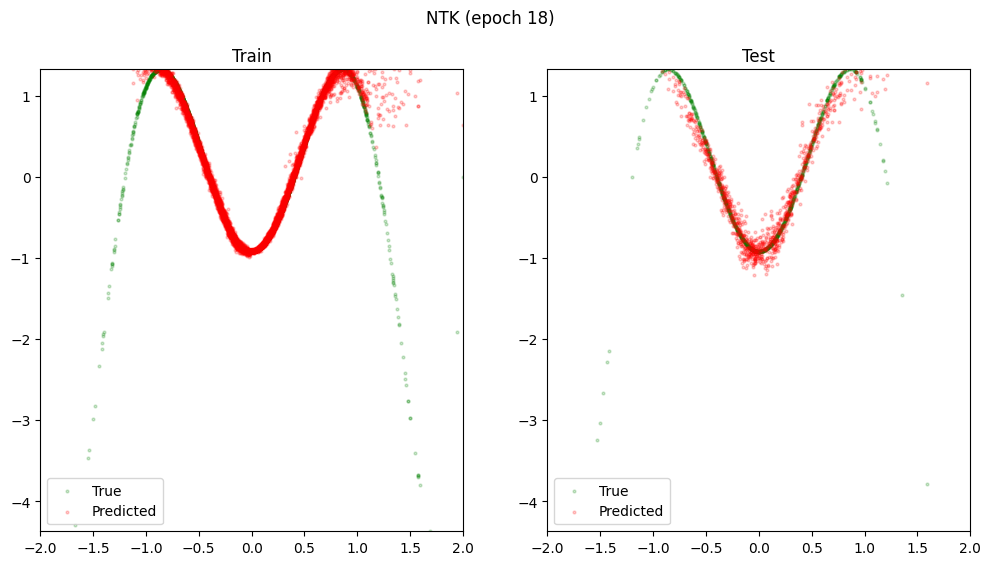

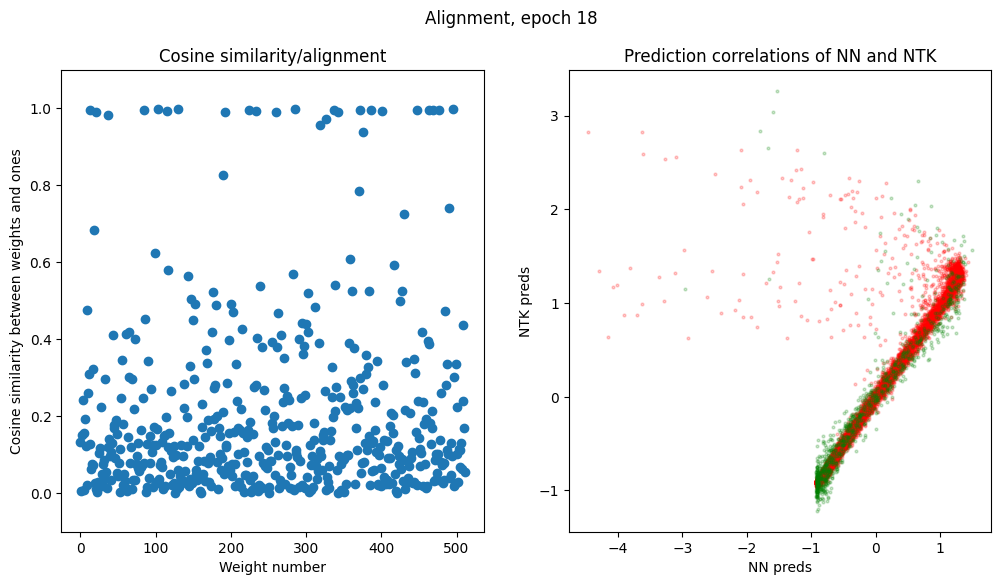

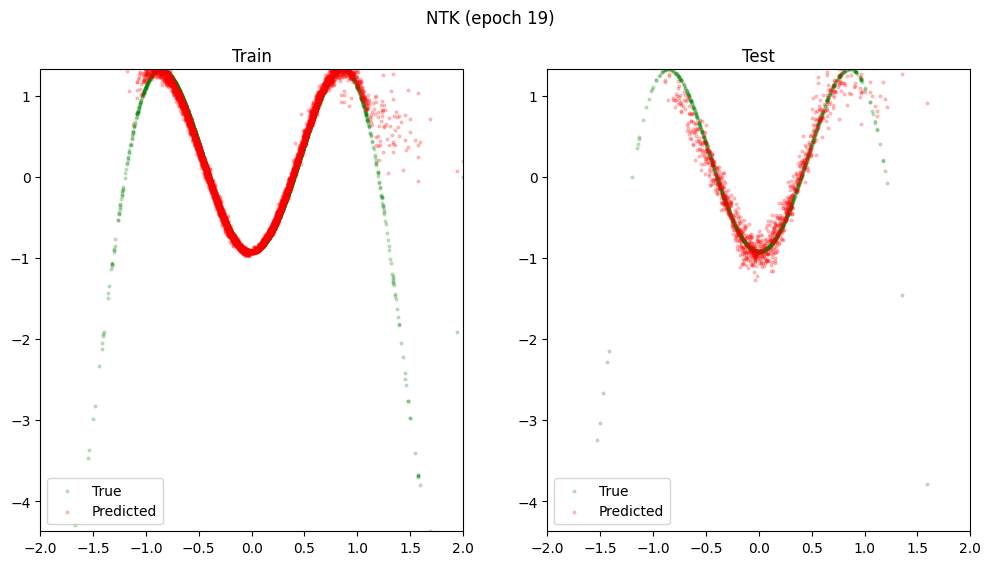

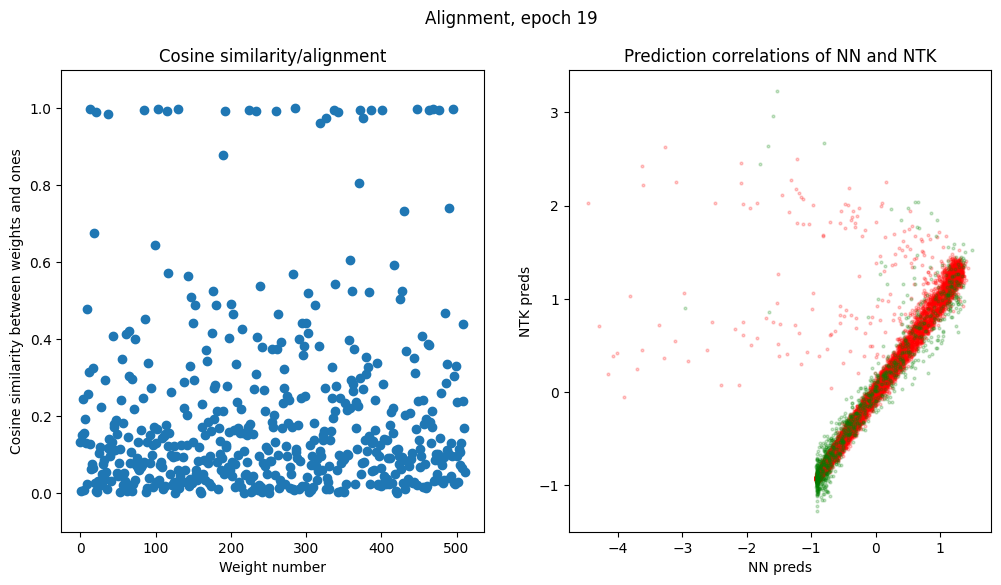

In [26]:
for epoch in KEY_EPOCHS:
    print(f'Beginning epoch {epoch}')
    file_name = f'degree_{DEGREE}_epoch_{epoch}'
    X_train_ntk = get_ntk_feature_matrix(X_train, models[epoch])
    X_val_ntk = get_ntk_feature_matrix(X_val, models[epoch])
    X_test_ntk = get_ntk_feature_matrix(X_test, models[epoch])
    model_cv_ntk.fit(X_train_ntk, Y_train.squeeze())
    best_params_ntk = model_cv_ntk.best_params_
    best_score_ntk = max(model_cv_ntk.cv_results_['mean_test_score'])
    print(f'Best C: {best_params_ntk["C"]}, best score: {best_score_ntk}')
    best_model_km = LinearSVR(C=best_params_ntk['C'])
    best_model_km.fit(X_train_ntk, Y_train.squeeze())
    preds_train_km, preds_val_km, preds_test_km = best_model_km.predict(X_train_ntk), best_model_km.predict(X_val_ntk), best_model_km.predict(X_test_ntk)
    score_train, score_val, score_test = mean_squared_error(Y_train.squeeze(), preds_train_km), mean_squared_error(Y_val.squeeze(), preds_val_km), mean_squared_error(Y_test.squeeze(), preds_test_km)

    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.scatter(X_train.sum(dim=1), Y_train, c='g', label='True', s=4, alpha=0.2)
    plt.scatter(X_train.sum(dim=1), preds_train_km, c='r', label='Predicted', s=4, alpha=0.2)
    plt.title('Train')
    plt.xlim(-RANGE, RANGE)
    plt.ylim(Y_LIM)
    plt.legend()

    plt.subplot(122)
    plt.scatter(X_test.sum(dim=1), Y_test, c='g', label='True', s=4, alpha=0.2)
    plt.scatter(X_test.sum(dim=1), preds_test_km, c='r', label='Predicted', s=4, alpha=0.2)
    plt.title('Test')
    plt.xlim(-RANGE, RANGE)
    plt.ylim(Y_LIM)
    plt.legend()

    plt.suptitle(f'NTK (epoch {epoch})')
    plt.savefig(f'plots/alignments/fits/{file_name}')

    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    cosines = get_cosine_angles(models[epoch])
    plt.scatter(range(len(cosines)), cosines.abs())
    plt.ylim(-0.1, 1.1)
    plt.ylabel('Cosine similarity between weights and ones')
    plt.xlabel('Weight number')
    plt.title('Cosine similarity/alignment')

    plt.subplot(122)
    plt.scatter(preds_train_nn.squeeze(), preds_train_km, c='r', label='Train', s=4, alpha=0.2)
    plt.scatter(preds_test_nn.squeeze(), preds_test_km, c='g', label='Test', s=4, alpha=0.2)
    plt.xlabel('NN preds')
    plt.ylabel('NTK preds')
    plt.title('Prediction correlations of NN and NTK')
    
    plt.suptitle(f'Alignment, epoch {epoch}')
    plt.savefig(f'plots/alignments/alignments/{file_name}')